In [2]:
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
from PIL import Image, ImageChops, ImageEnhance
import os
import joblib

In [3]:
import tensorflow as tf

In [4]:
PATH = '/Users/nafeessiddiqui/PycharmProjects/pythonProject8/CASIA2/'


In [5]:
# PATH_TP='./dataset/CASIA2/Tp/'
data_label = ['Au', 'Tp']
label_lst = []
img_lst = []
for label in data_label:
    # print(label)
    # print(os.listdir(PATH+label))
    for img_file in os.listdir(PATH+label):
        img_lst.append(PATH+label+'/'+img_file)
        label_lst.append(label)
    # print(label_lst)


df = pd.DataFrame({'img': img_lst, 'label': label_lst})
df.head()

,img,label
0,/Users/nafeessiddiqui/PycharmProjects/pythonPr...,Au
1,/Users/nafeessiddiqui/PycharmProjects/pythonPr...,Au
2,/Users/nafeessiddiqui/PycharmProjects/pythonPr...,Au
3,/Users/nafeessiddiqui/PycharmProjects/pythonPr...,Au
4,/Users/nafeessiddiqui/PycharmProjects/pythonPr...,Au


In [7]:
path_resaved = '/Users/nafeessiddiqui/PycharmProjects/pythonProject8/CASIA2/resaved/'


def difference(path):
    filename = path
    # print(path)
    resaved_name = filename.split('.')[-2]+'_resaved.jpg'
    # print(resaved_name)
    resaved_name = path_resaved+resaved_name.split('/')[-1]
    org = Image.open(filename).convert('RGB')
    org.save(resaved_name, 'JPEG', quality=92)
    resaved = Image.open(resaved_name)
    diff = ImageChops.difference(org, resaved)
    extrema = diff.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    diff = ImageEnhance.Brightness(diff).enhance(scale)
    # diff
    return diff

In [13]:
from pylab import *
from tensorflow.keras.utils import to_categorical

X = []
y = []

for index, row in df.iterrows():
    x = array(difference(row[0]).resize((128, 128))).flatten()/255.0
    X.append(x)
    if row[1] == 'Au':
        y.append(0)
    else:
        y.append(1)

X = np.array(X)
X = X.reshape(-1, 128, 128, 3)

Y = to_categorical(y, 2)

/var/folders/3x/x1lh43kj2j5gclx6y2nz7vnm0000gn/T/ipykernel_39301/1765412876.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = array(difference(row[0]).resize((128, 128))).flatten()/255.0
/var/folders/3x/x1lh43kj2j5gclx6y2nz7vnm0000gn/T/ipykernel_39301/1765412876.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[1] == 'Au':


UnidentifiedImageError: cannot identify image file '/Users/nafeessiddiqui/PycharmProjects/pythonProject8/CASIA2/Au/Thumbs.db'

In [16]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from tensorflow.keras.utils import to_categorical

# Define the path to the dataset
PATH = '/Users/nafeessiddiqui/Desktop/Projects/Image-Forgery-Detection-master 2/CASIA2'

# Define the labels
data_label = ['Au', 'Tp']
label_lst = []
img_lst = []

# Supported image file extensions
image_extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.gif']

# Loop through the labels and image files to create lists of file paths and labels
for label in data_label:
    for img_file in os.listdir(os.path.join(PATH, label)):
        if os.path.splitext(img_file)[1].lower() in image_extensions:
            img_lst.append(os.path.join(PATH, label, img_file))
            label_lst.append(label)

# Create a DataFrame from the lists
df = pd.DataFrame({'img': img_lst, 'label': label_lst})

# Initialize lists to hold the data and labels
X = []
y = []

# Process each image and label
for index, row in df.iterrows():
    try:
        img = Image.open(row['img'])
        img = img.resize((128, 128))
        img = np.array(img).flatten() / 255.0
        X.append(img)
        if row['label'] == 'Au':
            y.append(0)
        else:
            y.append(1)
    except Exception as e:
        print(f"Error processing image {row['img']}: {e}")

# Convert lists to numpy arrays
X = np.array(X)
X = X.reshape(-1, 128, 128, 3)

# One-hot encode the labels
Y = to_categorical(y, 2)

print(X.shape)
print(Y.shape)


(9555, 128, 128, 3)
(9555, 2)


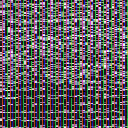

In [17]:
# x=difference(df['img'][9000]).resize((128, 128))
# # .flatten()/255.0
# x=array(x)
# print(x.shape)
# x.flatten().shape
# x
Image.fromarray(X[0], 'RGB')
# Image.fromarray(X[10].reshape((128,128,3)),'RGB')

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20,  shuffle=True, stratify=Y)

In [19]:
print(X_train.shape, X_test.shape)
print(type(Y))

(7644, 128, 128, 3) (1911, 128, 128, 3)
<class 'numpy.ndarray'>


In [20]:
Y.shape

(9555, 2)

In [21]:
# extra 

from tensorflow.keras.utils import Sequence
import numpy as np


class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y


train_gen = DataGenerator(X_train, y_train, 32)
test_gen = DataGenerator(X_test, y_test, 32)

In [22]:
def build_model(activation='sigmoid'):

    model = tf.keras.Sequential()
    # input layer
    model.add(tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32,
              input_shape=[128, 128, 3], activation='relu'))

    # hidden layers
    model.add(tf.keras.layers.Conv2D(filters=32, padding='valid',
              kernel_size=(3,3), activation='relu'))
    model.add(tf.keras.layers.Conv2D(filters=32, padding='valid',
              kernel_size=(5, 5), activation='relu'))
    # pooling
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=2, padding='valid', data_format='channels_last'))
    model.add(tf.keras.layers.Dropout(.50))
    # flatten
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(.25))
    
    # model.add(tf.keras.layers.Dense(256, activation='relu'))
    # model.add(tf.keras.layers.Dropout(.50))

    # output layer
    model.add(tf.keras.layers.Dense(2, activation=activation))
    return model

In [23]:
softmax_adam = build_model('softmax')
softmax_adam.summary()

/Users/nafeessiddiqui/PycharmProjects/pythonProject8/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 120, 120, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,527,746 (112.64 MB)

 Trainable params: 29,527,746 (112.64 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
X_train.shape

(7644, 128, 128, 3)

In [25]:
y_train.shape

(7644, 2)

In [52]:
# from sklearn.metrics import f1_score
from keras import metrics

adam = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-08)
epoch = 30
batch_size = 10
cal1 = tf.keras.callbacks.ModelCheckpoint(save_best_only=True, filepath='softmax_adam_n.keras')
cal2 = tf.keras.callbacks.EarlyStopping(patience=5)
# optimizer = RMSprop(lr=lr, rho=0.9, epsilon=1e-08, decay=0.0)
# softmax_adam.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=['accuracy'])
softmax_adam.compile(optimizer='adam', loss='binary_crossentropy',
                metrics=['accuracy', 'mse'])
history = softmax_adam.fit(train_gen, validation_data=test_gen,  epochs=epoch, callbacks=[cal1])
history = history.history
    

Epoch 1/30


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 128, 128, 1)

In [54]:
from keras import metrics

adam = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-08)
epoch = 30
batch_size = 10
cal1 = tf.keras.callbacks.ModelCheckpoint(save_best_only=True, filepath='softmax_adam_n.keras')
cal2 = tf.keras.callbacks.EarlyStopping(patience=5)

# Assuming you have defined your model here
softmax_adam = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # 1 neuron for binary classification
])

softmax_adam.compile(optimizer=adam, loss='binary_crossentropy',
                     metrics=['accuracy', 'mse'])

# Assuming train_gen and test_gen are your data generators
history = softmax_adam.fit(train_gen, validation_data=test_gen, epochs=epoch, callbacks=[cal1, cal2])

# Save the model
softmax_adam.save('softmax_adam_n.keras')

# Get the history
history = history.history
print(history)

Epoch 1/30


/Users/nafeessiddiqui/PycharmProjects/pythonProject8/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1010/1010 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5816 - loss: 0.6878 - mse: 0.2410

ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 2), output.shape=(None, 1)